# Install mamba and dependencies

In [ ]:
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=137750683 sha256=b264292652a34fb9dd0ce880a34a4407ba7256a3338388d056769ec29a4581c9
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm


In [ ]:
# from mamba_ssm import Mamba
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torchinfo import summary
from datetime import datetime
from helpers import *
# from einops import rearrange

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


In [ ]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-01-01")
train_start_date = pd.to_datetime("2020-01-01")
out_cols = ['pct_change']
learning_rate = 0.0001
outdims = len(out_cols)
epochs = 25
num_test_days = 50
batch_size = 32
d_model = 128 # number of input features to encoder layer
nhead = 32 # number of heads in multiheadattention
num_layers = 64 # number of encoder layers
dropout = 0.1 # dropout probability

# loading data
data_path = 'drive/MyDrive/data'
interval = '1d'
companies = os.listdir(data_path)
# companies = ['AAPL', 'GOOGL', 'NVDA', ]
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

companies = random.sample(companies, 10)

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

In [ ]:
def load_from_files(
    companies: list[str],
    ids: np.array,
    data_path: str,
    interval: str,
    train_start_date: pd.Timestamp,
    test_start_date: pd.Timestamp,
):
    company_stats = dict()  # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    df_list = []
    test_start_idx = dict()

    for co in companies:
        files = os.listdir(os.path.join(data_path, co))
        for f in files:  # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df["date"] = pd.to_datetime(df["date"])
        # remove blank column
        df = df.drop(columns=["Unnamed: 0"])
        # remove data before training start date
        df = df[df["date"] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, ["date", 'pct_change'])
        company_stats[co] = stat_dict
        # add ticker column
        df_normed["ticker"] = ticker_to_num[co]
        df_list.append(df_normed)

        # get index of test start date
        test_start_idx[co] = np.min(np.argmax(df_normed["date"] >= test_start_date))

    return df_list, test_start_idx, company_stats, num_to_ticker, ticker_to_num


def recreate_dataloaders(df_list: list[pd.DataFrame], seq_size: int, test_idx: dict, test_idx_offset: int):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    test_dates = dict() # should all be the same?

    for j, df_normed in enumerate(df_list):
        # save test date for respective company
        test_dates[companies[j]] = df_normed['date'].iloc[test_idx[companies[j]] + test_idx_offset]

        # drop date column before making sequences
        df_normed = df_normed.drop(columns=["date"])

        # store column indices for extracting output features we want
        feature_cols_idx = [
            list(df_normed.columns).index(feature) for feature in out_cols
        ]

        # convert to 2D numpy array of shape (-1, num_cols)
        data_arr = df_normed.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, data_arr)
        for i in range(len(x)):
            if i < test_idx[companies[j]] + test_idx_offset - seq_size:
                x_train.append(x[i])
                y_train.append(y[i])
            elif i == test_idx[companies[j]] + test_idx_offset - seq_size:
                x_test.append(x[i])
                y_test.append(y[i])


    indims = y_train[0].shape[0]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.array(x_test).reshape(-1, seq_size, indims)
    y_test = np.array(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, test_loader, indims, test_dates, feature_cols_idx


df_list, test_start_idx, company_stats, num_to_ticker, ticker_to_num = load_from_files(companies, ids, data_path, interval, train_start_date, test_start_date)
train_loader, test_loader, indims, test_dates, feature_cols_idx = recreate_dataloaders(df_list, seq_size, test_start_idx, test_idx_offset=0)



In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

class BigTransformer(nn.Module):
    def __init__(self, indim, outdim, hidden_dim=256, d_model=64, nhead=4, num_encoder_layers=6, num_decoder_layers=6):
        super(BigTransformer, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model)
        self.embedding = nn.Sequential(
            nn.Linear(indim, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
            )
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, batch_first=True)

        self.decoder_mlp = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, outdim)
        )

        self.d_model = d_model

    def forward(self, src):
        tgt = src[:,0,:].unsqueeze(1)
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)
        src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(tgt)).to(device)
        out = self.transformer(src, tgt, src_mask, tgt_mask, src_is_causal=True, tgt_is_causal=True)
        out = self.decoder_mlp(out)
        return out.squeeze(1)

model = BigTransformer(indims, outdims, 256, d_model, nhead, num_encoder_layers=6, num_decoder_layers=6).to(device)


# class MambaModel(nn.Module):
#     def __init__(self, input_dim=1, output_dim=1, seq_size=29, d_state=16, d_conv=4, expand=2, dropout=0.2):
#         super(MambaModel, self).__init__()
#         self.mamba = Mamba(d_model=input_dim, d_state=d_state, d_conv=d_conv, expand=expand)
#         self.d1_nn = nn.Dropout(p=dropout)
#         self.fc1 = nn.Linear(in_features=seq_size*input_dim, out_features=output_dim)

#     def forward(self, x):
#         y = self.mamba(x)
#         y = rearrange(y, 'B L F -> B (L F)') # flatten sequences
#         y = self.d1_nn(y)
#         y = self.fc1(y)
#         return y

# model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
# model = MambaModel(input_dim=indims, output_dim=outdims, seq_size=seq_size, d_state=32, d_conv=4, expand=4, dropout=0.1).to(device)

In [ ]:
# Train the model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

def train_loop(model, criterion, optimizer, scheduler, train_loader, test_loader, device, num_to_ticker, feature_cols_idx, test_dates, out_cols):
    early_stop_count = 0
    min_val_loss = float('inf')

    results = []
    gt_preds = []

    for d in range(num_test_days):
        # train a lot in the beginning, then only do a few epochs for fine tuning
        epochs = 20 if d == 0 else 10
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for batch in train_loader:
                x_batch, y_batch = batch
                y_batch = y_batch[:, feature_cols_idx]
                y_batch[y_batch <= 0] = 0
                y_batch[y_batch > 0] = 1
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                train_losses.append(loss.item())
                optimizer.step()

            # Validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in test_loader:
                    x_batch, y_batch = batch
                    y_batch = y_batch[:, feature_cols_idx]
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    outputs = model(x_batch)

                    y_batch[y_batch <= 0] = 0
                    y_batch[y_batch > 0] = 1
                    loss = criterion(outputs, y_batch)
                    val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            train_loss = np.mean(train_losses)

            print(f"Test day {d+1} Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # record test measurement
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
                y_batch = y_batch[:, feature_cols_idx]
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)

                gt_outputs = process_results_incremental(y_batch, test_dates, tickers)
                processed_outputs = process_results_incremental(torch.sigmoid(outputs), test_dates, tickers)
                [results.append(out) for out in processed_outputs]
                [gt_preds.append(out) for out in gt_outputs]

        train_loader, test_loader, indims, test_dates, feature_cols_idx = recreate_dataloaders(df_list, seq_size, test_start_idx, test_idx_offset=d + 1)

    columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
    df_pred = pd.DataFrame(results, columns=columns)
    df_gt = pd.DataFrame(gt_preds, columns=columns)
    df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
    df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
    df_merged = pd.merge(df_pred, df_gt, 'inner')

    return model, df_merged

model, df_merged = train_loop(model, criterion, optimizer, scheduler, train_loader, test_loader, device, num_to_ticker, feature_cols_idx, test_dates, out_cols)
df_merged.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: shape '[1, 1, 30, 30]' is invalid for input of size 100

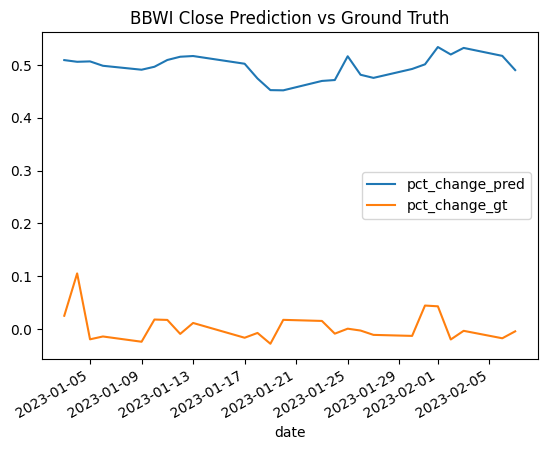

In [ ]:
co = companies[0]
df_merged[df_merged['ticker'] == co].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"{co} Close Prediction vs Ground Truth")
plt.show()

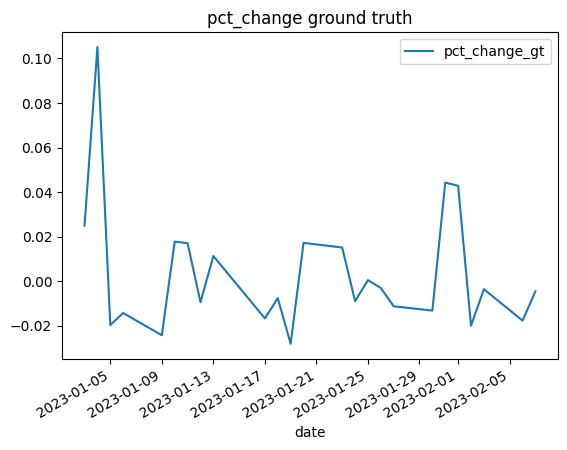

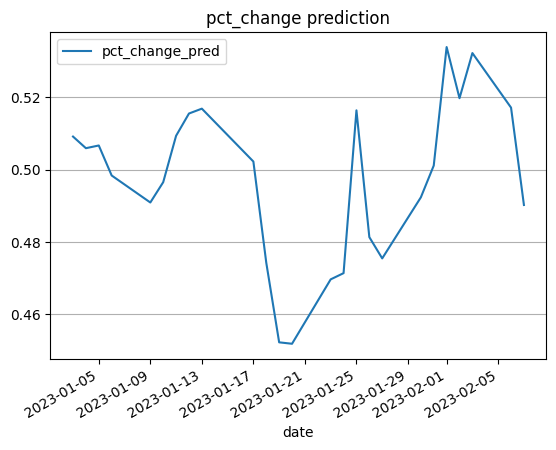

In [ ]:
df_merged[df_merged['ticker'] == co].plot(x='date', y='pct_change_gt')
plt.title("pct_change ground truth")
plt.show()
df_merged[df_merged['ticker'] == co].plot(x='date', y='pct_change_pred')
plt.grid(axis='y')
plt.title("pct_change prediction")
plt.show()

In [ ]:
accuracy_metrics = dict()
for i in range(len(companies)):
    accuracy_metrics[companies[i]] = dict()
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    da = directional_accuracy_prob(gt_rows, pred_rows)
    pct_increasing = (gt_rows >= 0).sum()/len(gt_rows)
    accuracy_metrics[companies[i]]["directional accuracy"] = da
    accuracy_metrics[companies[i]]["pct increasing"] = pct_increasing
    accuracy_metrics[companies[i]]["pred vs gt DA difference"] = da - pct_increasing

    print(f"{companies[i]} DA improvement over buy and hold: {accuracy_metrics[companies[i]]['pred vs gt DA difference']:.4f}")


BBWI DA improvement over buy and hold: -0.1200
PCAR DA improvement over buy and hold: -0.1600
EXPE DA improvement over buy and hold: -0.1600
AVGO DA improvement over buy and hold: -0.3200
MPWR DA improvement over buy and hold: -0.2400


In [ ]:
accuracy_metrics[companies[0]]

{'directional accuracy': 0.36,
 'pct increasing': 0.54,
 'pred vs gt DA difference': -0.18000000000000005}